In [1]:
wdir = "/home/user/data/gediminas/covid-phylogeny"
outfile = "analysis_large/tmp/haplotypes/haplotype_info_initial_clean_Sprotein_analysis.csv"
haplotype = "analysis_large/tmp/haplotypes/haplotype_info_initial_clean_Sprotein.csv.gz"
meta = "analysis_large/tmp/haplotypes/metadata_info_initial_clean.csv"
contacts = "analysis_large/rez/contacts_per_cluster.csv"
pangolin = "analysis_large/rez/pangolin_lineage_report.csv"
environment = "scripts/julia_modules/JuliaClusterAndTreeTools"
review = "/info_on_cluster_and_contacts_review.png"
all_trend = "/info_on_cluster_and_contacts_over_time_all.svg"
lt_trend = "/info_on_cluster_and_contacts_over_time_lt.svg"
taus = "/info_on_cluster_and_contacts_over_time.csv"
haplotypes = "/haplotype_info_lt_per_month.csv"
;

In [3]:
using Pkg
cd(wdir)
Pkg.activate(environment)
# using DataFramesMeta
using DataFrames
using ProgressMeter
using CSV
using CodecZlib
using InMemoryDatasets
using RCall
using Chain
R"""
library(dplyr)
library(tidyr)
library(ggplot2)
library(Kendall)
library(patchwork)
library(svglite)
library(data.table)
"""
;

  Activating project at `~/data/gediminas/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools`
┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall ~/.julia/packages/RCall/83M25/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘data.table’
│ 
│ The following objects are masked from ‘package:dplyr’:
│ 
│     between, first, last
│ 
└ @ RCall ~/.julia/packages/RCall/83M25/src/io.jl:172


In [4]:
haplotypedf = Dataset(CSV.File(haplotype))
;

In [5]:
metad = Dataset(CSV.File(meta))
;

In [6]:
# join with pangolin assignmant
pangolindf = Dataset(CSV.File(pangolin))
pangolindf =  @chain pangolindf begin
    InMemoryDatasets.select([:taxon,:lineage])
    InMemoryDatasets.filter(:lineage, by = !=("Unassigned"))
    InMemoryDatasets.rename(:lineage => :lineage_pangolin)
end
metad = InMemoryDatasets.leftjoin(metad,pangolindf, on = [:strain => :taxon], accelerate=true,makeunique=true)
;

In [7]:
# most abundant lineages per month
most_abund(x, y) = x[topkperm(y, 1)]
most_abundand_per_month = @chain metad begin
    InMemoryDatasets.groupby([:month,:lineage_pangolin])
    InMemoryDatasets.combine(:strain => length => :Count) 
    InMemoryDatasets.groupby([:month])
    InMemoryDatasets.combine((:lineage_pangolin,:Count) => most_abund => :month_strain) 
end
most_abundand_per_monthLT = @chain metad begin
    InMemoryDatasets.filter(:country, by = ==("Lithuania"))
    InMemoryDatasets.groupby([:month,:lineage_pangolin])
    InMemoryDatasets.combine(:strain => length => :Count) 
    InMemoryDatasets.groupby([:month])
    InMemoryDatasets.combine((:lineage_pangolin,:Count) => most_abund => :month_strainLT) 
end
;

In [8]:
#get LT sequences
m2h(x) = 1
LTseqs = @chain metad begin
    InMemoryDatasets.filter(:country, by = ==("Lithuania"))
    InMemoryDatasets.modify(:country => byrow(m2h) =>  :LT)
    InMemoryDatasets.rename(:strain => :seqname)
    InMemoryDatasets.select([:seqname,:LT])

end
;

In [9]:
dataP=InMemoryDatasets.select(haplotypedf, :seqname, :pos)
;

In [10]:
metadP=InMemoryDatasets.select(metad,:strain,:month,:lineage_pangolin)
;

In [11]:
dd3 =InMemoryDatasets.leftjoin(dataP,metadP, on = [ :seqname => :strain ], accelerate=true)
;

In [12]:
contactsdf = Dataset(CSV.File(contacts))
;

In [13]:
contactsdfExpl =  @chain contactsdf begin
    InMemoryDatasets.select([:Position], r"Cluster")
    DataFrame()
    stack(r"Cluster",variable_name="Cluster")
    Dataset()
    InMemoryDatasets.filter(:value, by= >(0)   )
    DataFrame()
end
@rput contactsdfExpl
;

In [14]:
# get contacts per cluster
R"""
contactsdfExpl_cnts <- contactsdfExpl %>%
    group_by(Cluster) %>%
    summarise(Position_number = n()) %>%
    ungroup()

contactsdfExpl_cnts 
"""

RObject{VecSxp}
# A tibble: 17 × 2
   Cluster     Position_number
   <chr>                 <int>
 1 Cluster_1                22
 2 Cluster_10                7
 3 Cluster_11               36
 4 Cluster_12               25
 5 Cluster_13                9
 6 Cluster_14               13
 7 Cluster_15               34
 8 Cluster_16               20
 9 Cluster_2                 9
10 Cluster_3                 8
11 Cluster_4                11
12 Cluster_5                14
13 Cluster_6                15
14 Cluster_7                 6
15 Cluster_8                18
16 Cluster_9                13
17 Cluster_all             219


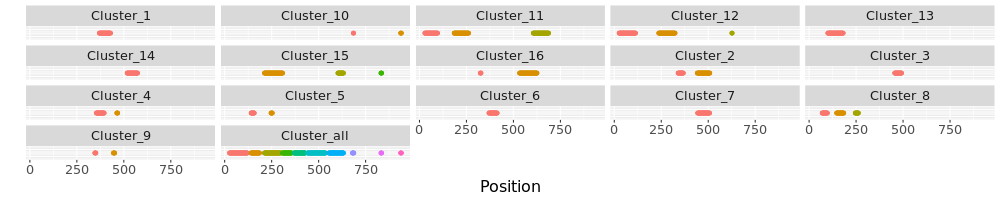

RObject{VecSxp}


In [15]:
# get positions per cluster
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 200))
R"""
# contactsdfExpl
# ggplot(contactsdfExpl)+geom_point(aes(x=Position,y=value)) + facet_grid(rows = vars(Cluster), scales = "free")
contactsdfExpl_clusters <- list()
contactsdfExpl_clusters_data_per_cluster <- list()
ct = 0 
for (cl in unique(contactsdfExpl$Cluster)){
    ct = ct + 1
    cldf = contactsdfExpl %>%
        filter(Cluster == cl)
    pos = cldf$Position
    d <- dist(pos, method = "euclidean")
    clusts <- cutree(hclust(d),h=100)
    cldf$Hclust <- clusts
   
    cldf_percluster <- cldf %>%
        group_by(Hclust) %>%
        summarise(N = n(),Pos = paste(min(Position),"-",max(Position),sep=""),Start = min(Position)) %>%
        filter(N > 1) %>%
        ungroup()
    cldf <- cldf %>%
        group_by(Hclust) %>%
        summarise(N = n(),Position = list(seq(min(Position),max(Position)))) %>%
        filter(N > 1) %>%
        ungroup()

    cldf$Cluster <- cl
    cldf_percluster$Cluster <- cl
    
    contactsdfExpl_clusters[[ct]] <- cldf
    contactsdfExpl_clusters_data_per_cluster[[ct]] <- cldf_percluster
}
contactsdfExpl_clusters <- bind_rows(contactsdfExpl_clusters)
contactsdfExpl_clusters <- unnest(contactsdfExpl_clusters, cols = c("Position"))
contactsdfExpl_clusters_data_per_cluster <- bind_rows(contactsdfExpl_clusters_data_per_cluster) %>%
    arrange(Cluster,Start) %>%
    group_by(Cluster) %>%
    summarise(Intervals = list(paste(Pos)),`Number of intervals` = length(Pos)) %>%
    ungroup() %>%
    mutate(Intervals=sapply(Intervals,paste,collapse = ",")) %>%
    left_join(contactsdfExpl_cnts, by = c("Cluster")) %>%
    rename(`Number of positions` = `Position_number`)

ggplot(contactsdfExpl_clusters)+geom_point(aes(x=Position,y=1, color = as.factor(Hclust))) + facet_wrap(vars(Cluster)) +
theme(axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      text=element_text(size=16)) +
labs(colour="Sequence cluster") +
guides(color = "none") +
ylab("")
"""

In [16]:
R"""
contactsdfExpl_clusters_data_per_cluster
"""

RObject{VecSxp}
# A tibble: 17 × 4
   Cluster     Intervals             `Number of intervals` `Number of positions`
   <chr>       <chr>                                 <int>                 <int>
 1 Cluster_1   369-430                                   1                    22
 2 Cluster_10  684-687,936-941                           2                     7
 3 Cluster_11  28-97,184-262,605-688                     3                    36
 4 Cluster_12  25-114,236-324,625-6…                     3                    25
 5 Cluster_13  99-182                                    1                     9
 6 Cluster_14  517-574                                   1                    13
 7 Cluster_15  211-309,602-633,831-…                     3                    34
 8 Cluster_16  323-328,532-626                           2                    20
 9 Cluster_2   339-368,441-509                           2                     9
10 Cluster_3   455-493                                   1                

In [17]:
dd4 =InMemoryDatasets.leftjoin(dd3,contactsdf, on= [ :pos => :Position], accelerate=true,check = false)
;

In [18]:
dd4 = @chain dd4 begin
    InMemoryDatasets.leftjoin(LTseqs, on = :seqname, accelerate=true)
end
;


In [19]:
clall =  @chain dd4 begin
                     InMemoryDatasets.view(:, [:seqname, :pos,:month,:Cluster_all,:LT,:lineage_pangolin])
                     InMemoryDatasets.filter(:Cluster_all, by = >(0), missings = true)
                   end
;

In [20]:
counts_per_month =  @chain clall begin
                     InMemoryDatasets.view(:, [:seqname,:month])
                     InMemoryDatasets.groupby(:month)
                     InMemoryDatasets.combine(:seqname => length => :N_sequences)
                   end
counts_per_monthLT =  @chain clall begin
                     InMemoryDatasets.filter(:LT,by = ==(1), missings=false)
                     InMemoryDatasets.view(:, [:seqname,:month])
                     InMemoryDatasets.groupby(:month)
                     InMemoryDatasets.combine(:seqname => length => :N_sequences)
                   end
counts_per_month_df = DataFrame(counts_per_month)
counts_per_monthLT_df = DataFrame(counts_per_monthLT)


@rput counts_per_monthLT_df
@rput counts_per_month_df
;

┌ Warning: RCall.jl: Warning: Removed 1 row containing missing values (`geom_line()`).
└ @ RCall ~/.julia/packages/RCall/83M25/src/io.jl:172


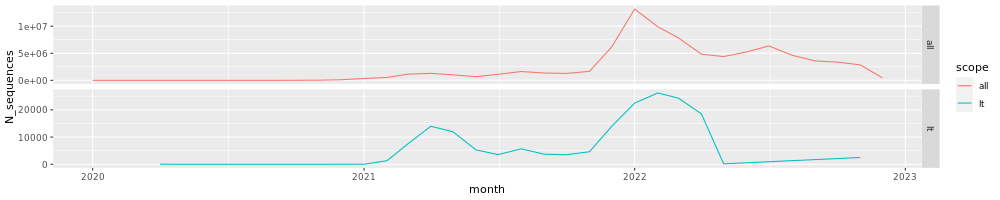

RObject{VecSxp}


In [21]:
#plot counts per month
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 200))
R"""
counts_per_monthLT_df$scope <- "lt"
counts_per_month_df$scope <- "all"
counts_per_monthboth_df <- bind_rows(counts_per_monthLT_df,counts_per_month_df )

ggplot(counts_per_monthboth_df) + geom_line(aes(x=month,y=N_sequences, color = scope)) +
facet_grid(rows = vars(scope), scales = "free") 

# theme(text=element_text(size=16),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
# xlab("Month") +
# ylab("Number of mutations")

"""

In [22]:
#Do in general counts increases going throught time

In [23]:
mutationcounts_per_month =  @chain clall begin
    InMemoryDatasets.view(:, [:pos,:month,:seqname,:lineage_pangolin])
    InMemoryDatasets.groupby([:month,:seqname,:lineage_pangolin])
    InMemoryDatasets.combine(:pos => length => :N_mutations) 
    #InMemoryDatasets.groupby([:month])
    #InMemoryDatasets.combine(:N_mutations => median => :N_mutations)
    InMemoryDatasets.dropmissing()
    InMemoryDatasets.leftjoin(LTseqs,on = :seqname)
    InMemoryDatasets.leftjoin(most_abundand_per_month, on = :month)
    InMemoryDatasets.leftjoin(most_abundand_per_monthLT, on = :month)
    DataFrame()
end
;                     

In [24]:
@rput mutationcounts_per_month
;

┌ Warning: RCall.jl: Warning: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
│ ℹ Please use `linewidth` instead.
└ @ RCall ~/.julia/packages/RCall/83M25/src/io.jl:172


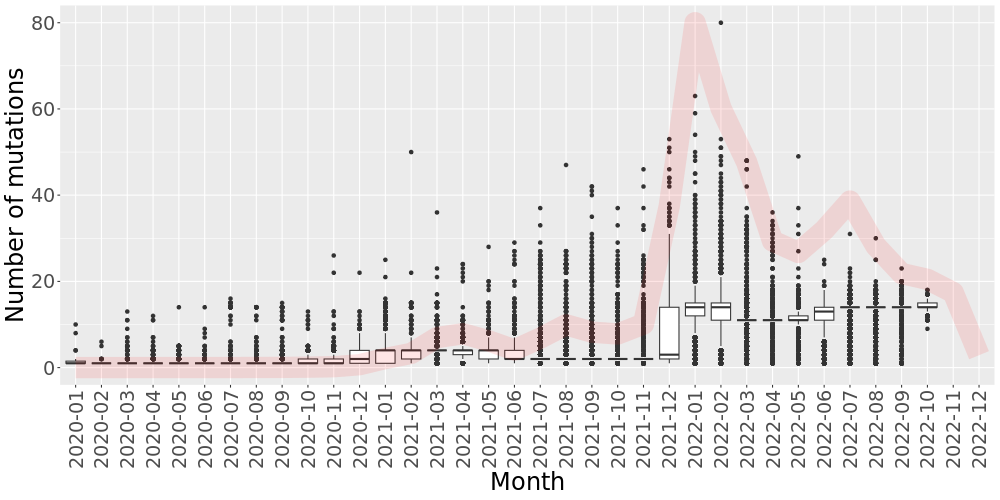

RObject{VecSxp}


In [25]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500))
R"""
counts_per_month_df$N_sequences_4plot = counts_per_month_df$N_sequences/max(counts_per_month_df$N_sequences )*max(mutationcounts_per_month$N_mutations)
mutationcounts_per_month$month <- format(mutationcounts_per_month$month, "%Y-%m")

counts_per_month_dfwona <- drop_na(counts_per_month_df)
counts_per_month_dfwona$month <- format(counts_per_month_dfwona$month, "%Y-%m")


plot_mutationcounts_per_month <- ggplot(mutationcounts_per_month) + geom_boxplot(aes(x=as.factor(month),y=N_mutations)) +
theme(text=element_text(size=24),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
xlab("Month") +
ylab("Number of mutations") +
geom_line(data = counts_per_month_dfwona, aes(x=factor(month),y=N_sequences_4plot, group=1),alpha = 0.1, size = 10, color = "red") 
"""

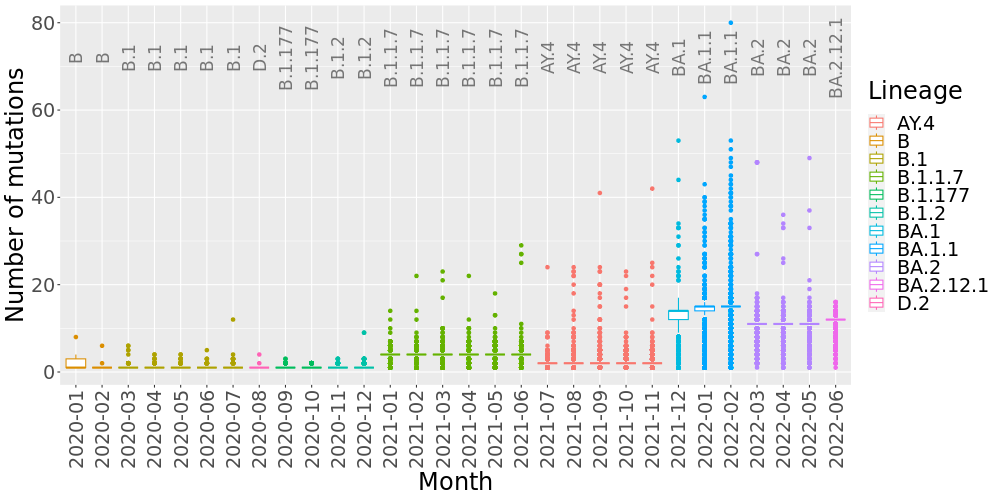

RObject{VecSxp}


In [26]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500))

R"""
mutationcounts_per_month_most_abund_lineage <- mutationcounts_per_month %>%
    filter(lineage_pangolin == month_strain)


labels_df <- mutationcounts_per_month_most_abund_lineage %>%
    group_by(month) %>%
    summarise(lineage_pangolin = first(lineage_pangolin)) %>%
    mutate(Y=max(mutationcounts_per_month_most_abund_lineage$N_mutations)*0.9, alpha = 0.2) %>%
    ungroup()

plot_mutationcounts_per_month_most_abund_lineage <- ggplot(mutationcounts_per_month_most_abund_lineage) + geom_boxplot(aes(x=as.factor(month), color = lineage_pangolin ,y=N_mutations)) +
theme(text=element_text(size=24),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
geom_text(data = labels_df,
aes(label=lineage_pangolin,x = as.factor(month), y = Y), angle=90,size = 6, alpha = 0.5) +
xlab("Month") +
ylab("Number of mutations") +
guides(color=guide_legend(title="Lineage"))
"""

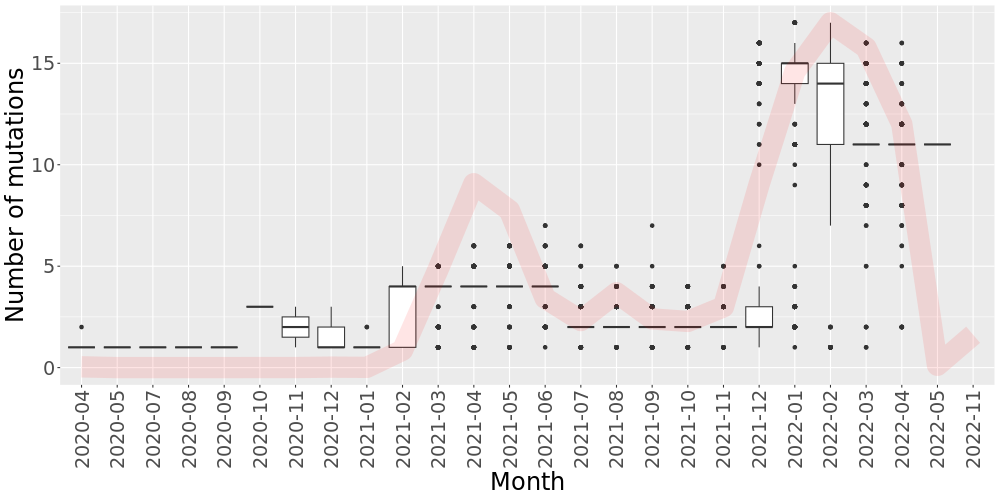

RObject{VecSxp}


In [27]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500))
R"""
mutationcounts_per_monthLT <- mutationcounts_per_month %>%
    filter(LT == 1)

counts_per_monthLT_df$N_sequences_4plot = counts_per_monthLT_df$N_sequences/max(counts_per_monthLT_df$N_sequences )*max(mutationcounts_per_monthLT$N_mutations)
counts_per_monthLT_dfwona <- drop_na(counts_per_monthLT_df)
counts_per_monthLT_dfwona$month <- format(counts_per_monthLT_dfwona$month, "%Y-%m")


plot_mutationcounts_per_monthLT <- ggplot(mutationcounts_per_monthLT) + geom_boxplot(aes(x=as.factor(month),y=N_mutations)) +
theme(text=element_text(size=24),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
xlab("Month") +
ylab("Number of mutations") +
geom_line(data = counts_per_monthLT_dfwona, aes(x=factor(month),y=N_sequences_4plot, group=1),alpha = 0.1, size = 10, color = "red") 

"""

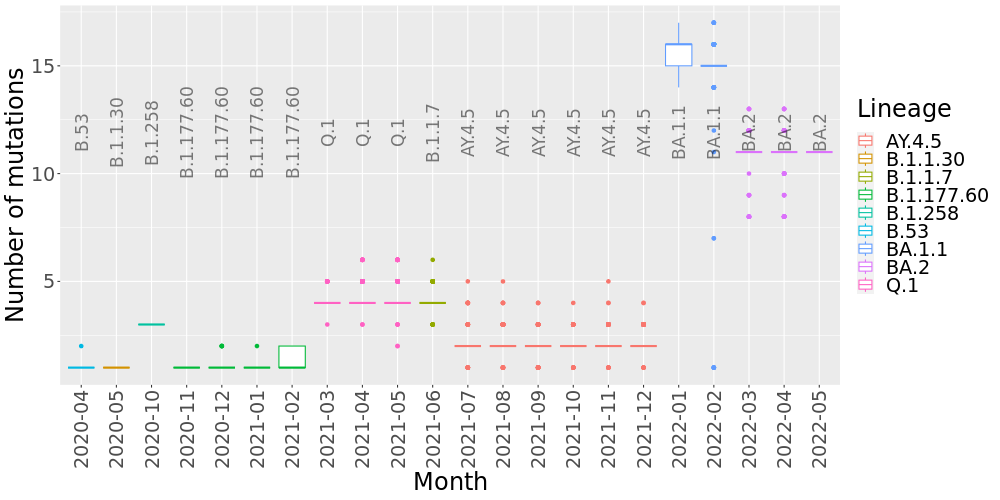

RObject{VecSxp}


In [28]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500))
R"""
mutationcounts_per_month_most_abund_lineageLT <- mutationcounts_per_monthLT %>%
    filter(lineage_pangolin == month_strainLT)
labels_df <- mutationcounts_per_month_most_abund_lineageLT %>%
    group_by(month) %>%
    summarise(lineage_pangolin = first(lineage_pangolin)) %>%
    mutate(Y=max(mutationcounts_per_month_most_abund_lineageLT$N_mutations*0.7), alpha = 0.2) %>%
    ungroup()

plot_mutationcounts_per_month_most_abund_lineageLT <- ggplot(mutationcounts_per_month_most_abund_lineageLT) + geom_boxplot(aes(x=as.factor(month), color = lineage_pangolin ,y=N_mutations)) +
theme(text=element_text(size=24),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
geom_text(data = labels_df,
aes(label=lineage_pangolin,x = as.factor(month), y = Y), angle=90,size = 6, alpha = 0.5) +
xlab("Month") +
ylab("Number of mutations") + 
guides(color=guide_legend(title="Lineage"))
plot_mutationcounts_per_month_most_abund_lineageLT
"""

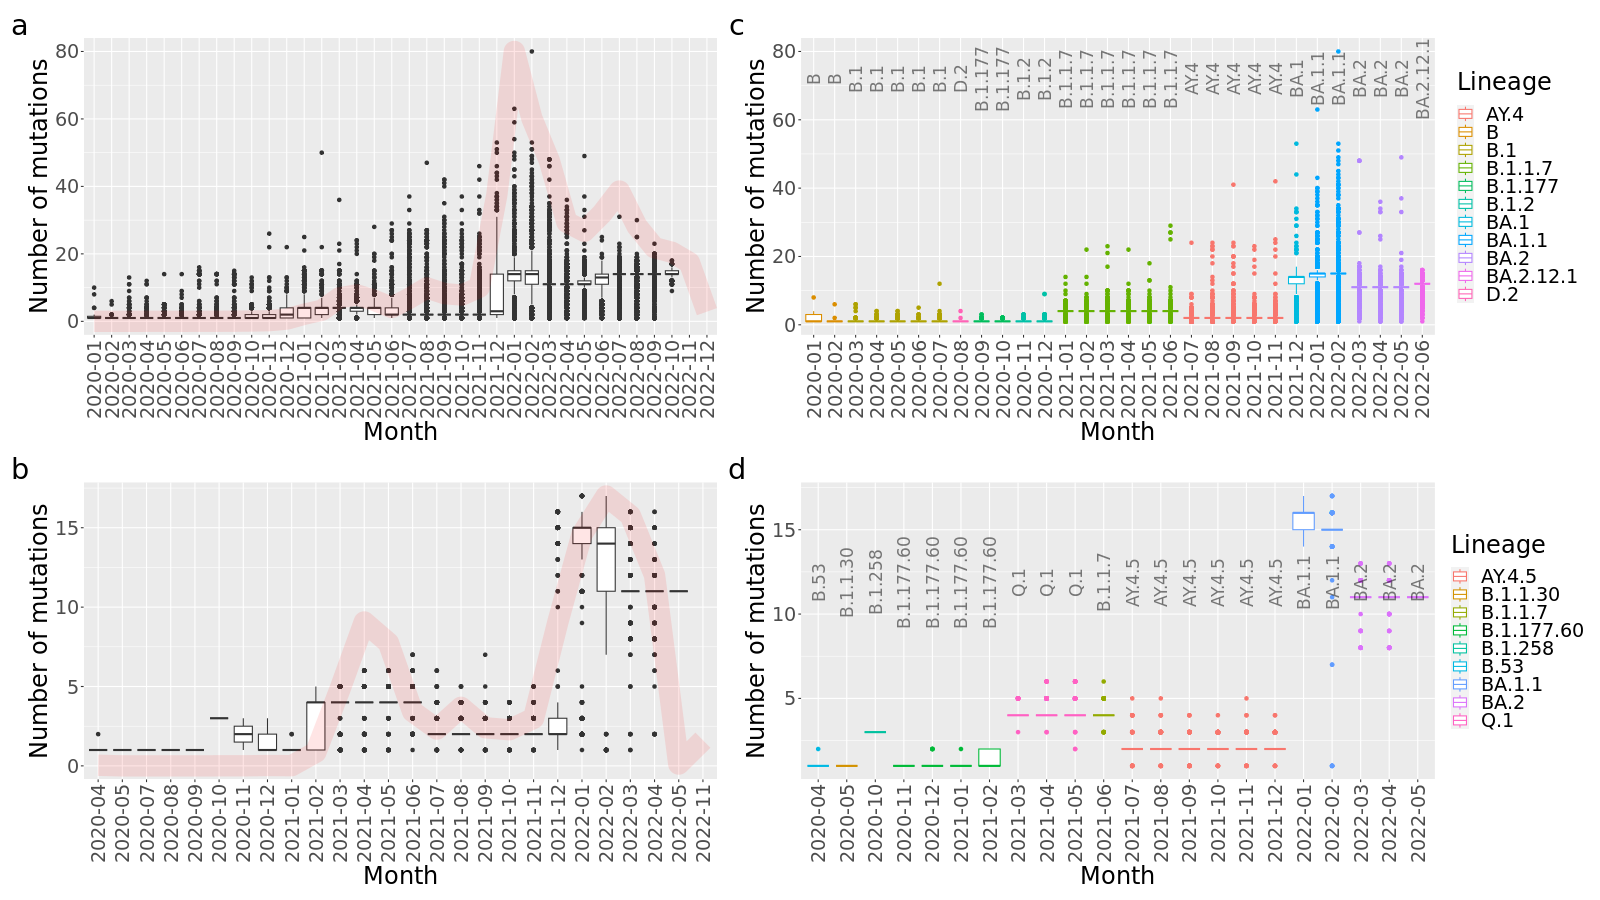

RObject{VecSxp}


In [29]:
#Get pot for all plots

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1600, :height => 900))

R"""
plots_contacts <- (plot_mutationcounts_per_month/plot_mutationcounts_per_monthLT)|(plot_mutationcounts_per_month_most_abund_lineage/plot_mutationcounts_per_month_most_abund_lineageLT) 
plots_contacts <- plots_contacts + plot_annotation(tag_levels = 'a')
plots_contacts
"""


In [30]:
mutationcounts_per_month_per_clu = @chain dd4 begin
    InMemoryDatasets.groupby([:month,:seqname])
    InMemoryDatasets.combine( r"Cluster_" => sum )
    InMemoryDatasets.groupby([:month])
    InMemoryDatasets.combine( r"Cluster_" => median )
    InMemoryDatasets.dropmissing()
    DataFrame()
end
;

In [31]:
mutationcounts_per_month_per_cluLT = @chain dd4 begin
    InMemoryDatasets.filter(:LT, by =  ==(1), missings = false)
    InMemoryDatasets.groupby([:month,:seqname])
    InMemoryDatasets.combine( r"Cluster_" => sum )
    InMemoryDatasets.groupby([:month])
    InMemoryDatasets.combine( r"Cluster_" => median )
    InMemoryDatasets.dropmissing()
    DataFrame()
end
;

In [32]:
function renF(x)
    out = replace.(x,"median_sum_"=>"")
    return(out)
end

mutationcounts_per_month_per_clu_transp = transpose(gatherby(Dataset(mutationcounts_per_month_per_clu), :month, isgathered = true), r"median")
InMemoryDatasets.rename!(mutationcounts_per_month_per_clu_transp,["_variables_"=>"Cluster","_c1"=>"Number_of_contacts"])
modify!(mutationcounts_per_month_per_clu_transp, :Cluster => renF => :Cluster)
mutationcounts_per_month_per_clu_transp = DataFrame(mutationcounts_per_month_per_clu_transp)


mutationcounts_per_month_per_clu_transpLT = transpose(gatherby(Dataset(mutationcounts_per_month_per_cluLT), :month, isgathered = true), r"median")
InMemoryDatasets.rename!(mutationcounts_per_month_per_clu_transpLT,["_variables_"=>"Cluster","_c1"=>"Number_of_contacts"])
modify!(mutationcounts_per_month_per_clu_transpLT, :Cluster => renF => :Cluster)
mutationcounts_per_month_per_clu_transpLT = DataFrame(mutationcounts_per_month_per_clu_transpLT)



;

In [33]:
@rput mutationcounts_per_month_per_clu_transp mutationcounts_per_month_per_clu_transpLT
;

In [34]:
R"""

mutationcounts_per_month_per_clu_transp$Cluster <- sub("Cluster_","",mutationcounts_per_month_per_clu_transp$Cluster)

MKdf <- pivot_wider(mutationcounts_per_month_per_clu_transp, names_from=Cluster, values_from = Number_of_contacts) %>%
    select(-month)
test <- apply(MKdf,2,MannKendall)
ps <- list()
taus <- list()

ct = 0
for (n in names(test)){
    ct = ct + 1
    rez = test[[n]]
    taus[[ct]] = round(as.double(rez$tau), digits = 2)
    ps[[ct]] = as.double(rez$sl)
}

KD = data.frame(Cluster = names(test), tau=unlist(taus), p = unlist(ps)) %>%
    mutate(tau=if_else(p<0.05,tau,NA))
d_label = mutationcounts_per_month_per_clu_transp %>%
    group_by(Cluster) %>%
    summarise(month=min(month), Number_of_contacts = median(Number_of_contacts)) %>%
    left_join(KD, by="Cluster")
# reorder based on KD
KD <- KD %>%
    arrange(-tau,p)
mutationcounts_per_month_per_clu_transp$Cluster = factor(mutationcounts_per_month_per_clu_transp$Cluster, levels = KD$Cluster)
d_label$Cluster = factor(d_label$Cluster, levels = KD$Cluster)

"""
;

In [35]:
R"""
head(data.frame(mutationcounts_per_month_per_clu_transpLT))
"""

RObject{VecSxp}
       month   Cluster Number_of_contacts
1 2020-04-01 Cluster_1                  0
2 2020-04-01 Cluster_2                  0
3 2020-04-01 Cluster_3                  0
4 2020-04-01 Cluster_4                  0
5 2020-04-01 Cluster_5                  0
6 2020-04-01 Cluster_6                  0


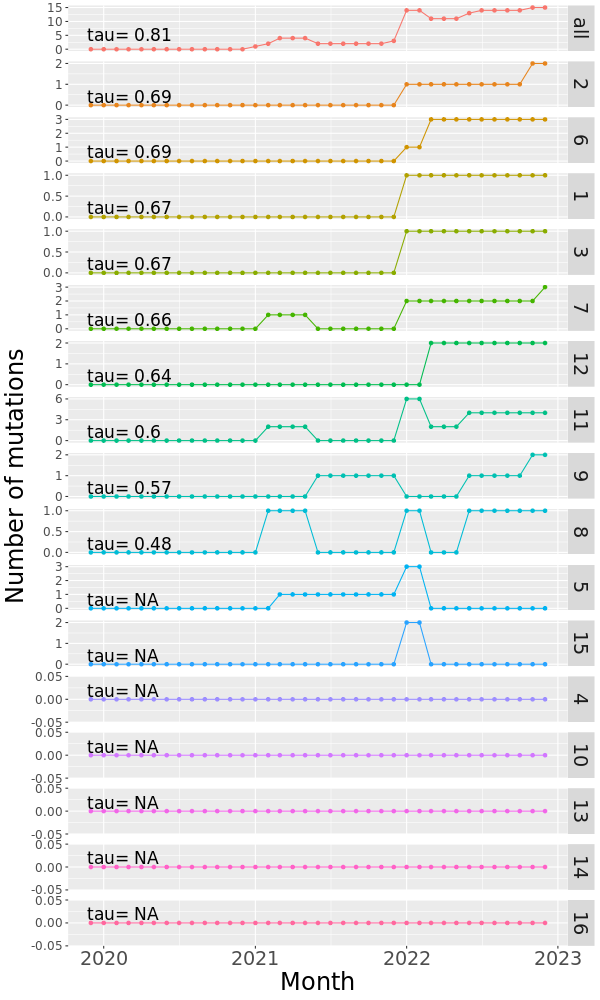

RObject{VecSxp}


In [36]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 1000))

R"""
mutationcounts_per_month_per_clu_transp$month <- as.Date(mutationcounts_per_month_per_clu_transp$month)
taus_per_cluster <- ggplot(mutationcounts_per_month_per_clu_transp) + geom_line(aes(x=month,y=Number_of_contacts, color = Cluster), group=1) + 
geom_point(aes(x=month,y=Number_of_contacts, color = Cluster)) +
facet_grid(rows = vars(Cluster), scales = "free") + 
xlab("Month") + ylab("Number of mutations") + geom_text(data = d_label, aes(label=paste("tau=",tau), x=month,y=Number_of_contacts),size=6, hjust=0.05, vjust = -0.2)+
guides(color="none") +
theme(text=element_text(size=24), axis.text.y = element_text(size=12), panel.spacing = unit(0.7, "lines")) +
scale_y_continuous(n.breaks=3) +
scale_x_date(date_breaks = "1 year", date_labels =  "%Y")

"""


In [37]:
R"""
mutationcounts_per_month_per_clu_transpLT$Cluster <- sub("Cluster_","",mutationcounts_per_month_per_clu_transpLT$Cluster)

MKdfLT <- pivot_wider(mutationcounts_per_month_per_clu_transpLT, names_from=Cluster, values_from = Number_of_contacts) %>%
    select(-month)


test <- apply(MKdfLT,2,MannKendall)
ps <- list()
taus <- list()

ct = 0
for (n in names(test)){
    ct = ct + 1
    rez = test[[n]]
    taus[[ct]] = round(as.double(rez$tau), digits = 2)
    ps[[ct]] = as.double(rez$sl)
}

KDLT = data.frame(Cluster = names(test), tau=unlist(taus), p = unlist(ps)) %>%
    mutate(tau=if_else(p<0.05,tau,NA))

d_labelLT = mutationcounts_per_month_per_clu_transpLT %>%
    group_by(Cluster) %>%
    summarise(month=min(month), Number_of_contacts = median(Number_of_contacts)) %>%
    left_join(KDLT, by="Cluster")

# # reorder based on KD
KDLT <- KDLT %>%
    arrange(-tau,p)
mutationcounts_per_month_per_clu_transpLT$Cluster = factor(mutationcounts_per_month_per_clu_transpLT$Cluster, levels = KDLT$Cluster)
d_labelLT$Cluster = factor(d_labelLT$Cluster, levels = KDLT$Cluster)
"""
;

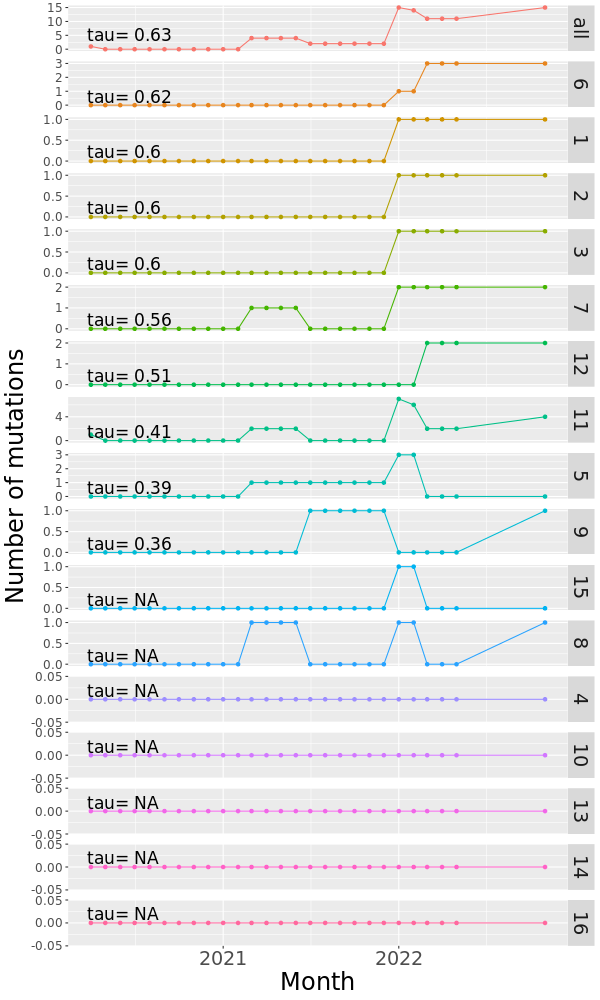

RObject{VecSxp}


In [38]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 1000))

R"""
taus_per_clusterLT <- ggplot(mutationcounts_per_month_per_clu_transpLT) + geom_line(aes(x=month,y=Number_of_contacts, color = Cluster)) + 
geom_point(aes(x=month,y=Number_of_contacts, color = Cluster)) +
facet_grid(rows = vars(Cluster), scales = "free") + 
xlab("Month") + ylab("Number of mutations") + geom_text(data = d_labelLT, aes(label=paste("tau=",tau), x=month,y=Number_of_contacts),size=6, hjust=0.05, vjust = -0.2)+
guides(color="none") +
theme(text=element_text(size=24), axis.text.y = element_text(size=12), panel.spacing = unit(0.7, "lines")) +
scale_y_continuous(n.breaks=3) +
scale_x_date(date_breaks = "1 year", date_labels =  "%Y") 

"""


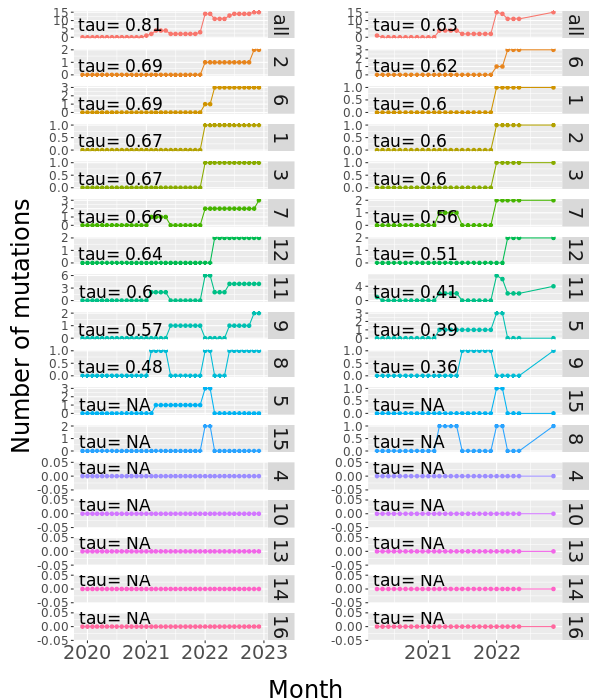

RObject{VecSxp}


In [39]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 700))
R"""
indiv_clusters <- ( (taus_per_cluster + xlab("")) | (taus_per_clusterLT + ylab("") + xlab("")) ) +
  labs(tag = "Month") +
  theme(
    plot.tag = element_text(size = rel(1)),
    plot.tag.position = c(0,0)
  )
"""

In [40]:
#R"""
#ggsave(file="test2.png", plot=indiv_clusters, width=600*10, height=1000*10, units="px", dpi=72*10, limitsize = F)
#"""
#;

LoadError: UndefVarError: `val` not defined

In [41]:
R"""
names(mutationcounts_per_month_most_abund_lineageLT)
fwrite(x = mutationcounts_per_month_most_abund_lineageLT, file = "mutationcounts_per_month_most_abund_lineageLT.tsv")
"""

RObject{NilSxp}
NULL


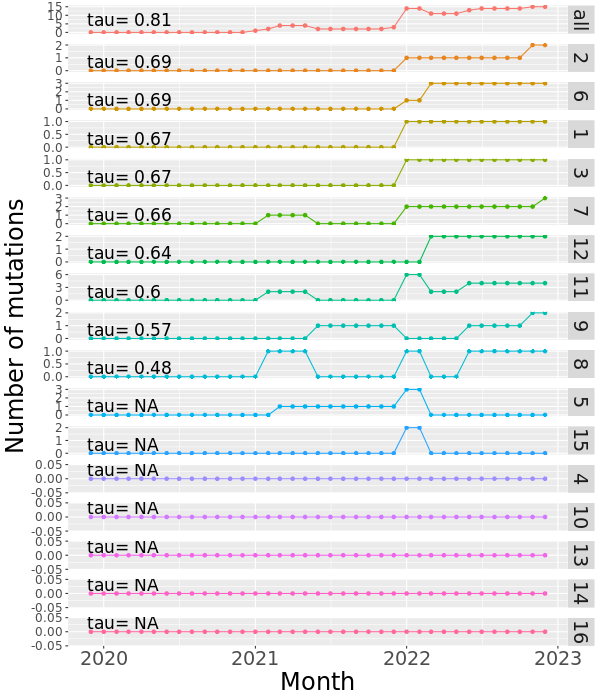

RObject{VecSxp}


In [42]:
R"""
taus_per_cluster
"""

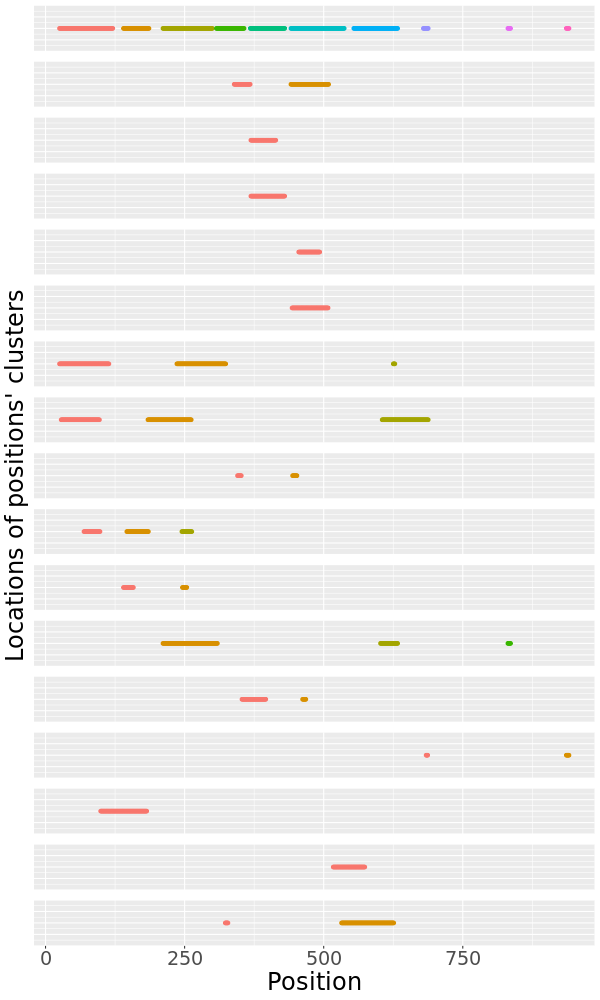

RObject{VecSxp}


In [43]:
#mutationcounts_per_month_per_clu_transp$Cluster = factor(mutationcounts_per_month_per_clu_transp$Cluster, levels = KD$Cluster)
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 1000))
R"""
contactsdfExpl_clusters2 <- contactsdfExpl_clusters %>%
    mutate(Cluster=sub("Cluster_","",Cluster))
contactsdfExpl_clusters2$Cluster = factor(contactsdfExpl_clusters2$Cluster, levels = KD$Cluster)
contactsdfExpl_clusters2_plot <- ggplot(contactsdfExpl_clusters2)+geom_point(aes(x=Position,y=1, color = as.factor(Hclust))) + 
facet_grid(rows = vars(Cluster), scales = "free") + 
theme(axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      text=element_text(size=24),
      panel.spacing = unit(0.7, "lines"),
      strip.background = element_blank(),
      strip.text.y = element_blank()
) +
labs(colour="Sequence cluster") +
guides(color = "none") +
ylab("Locations of positions' clusters")

"""

# Assemble outputs

In [68]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1600, :height => 900))
@rput review
R"""
out1 <- plots_contacts
out1
ggsave(file=review, plot=out1, width=1600*10, height=900*10, units="px", dpi=72*10, limitsize = F)
"""

RObject{StrSxp}
[1] "analysis_large/rez/info_on_cluster_and_contacts_review.png"


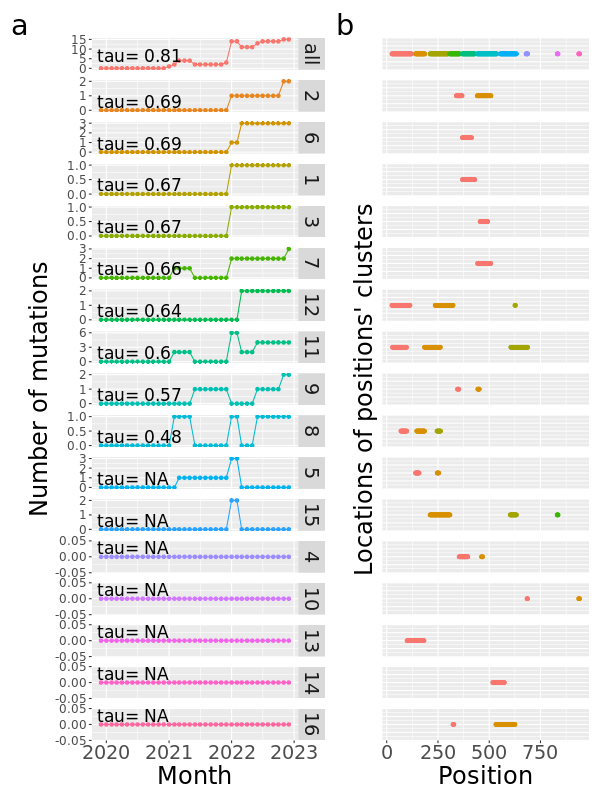

RObject{VecSxp}


In [63]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 800))
#Woldwide taus
@rput all_trend
R"""
out2 <- taus_per_cluster | contactsdfExpl_clusters2_plot
out2 <- out2 +  plot_annotation(tag_levels = 'a')
ggsave(all_trend, plot = out2, width = 600*5, height = 800*5, limitsize = FALSE, units = "px")
out2
"""

In [64]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 400, :height => 720))
#local (LT) stuff
@rput lt_trend
R"""
out3 <- taus_per_clusterLT + theme(text=element_text(size=24), axis.text.y = element_text(size=11), panel.spacing = unit(0.5, "lines"))
out3
ggsave(lt_trend, plot = out3, width = 400*5, height = 720*5, limits = F, units = "px")
"""

RObject{StrSxp}
[1] "analysis_large/rez/info_on_cluster_and_contacts_over_time_lt.svg"


In [65]:
@rput taus
R"""
out4 <- contactsdfExpl_clusters_data_per_cluster %>%
    mutate(Cluster = sub("Cluster_","", Cluster))
KDLTv2 <- KDLT %>%
    mutate(`tau (lt)` = round(tau, digits = 2), `p (lt)` = round(p, digits = 4)) %>%
    select(-p, -tau)
KDv2 <- KD %>%
    mutate(`tau (all)` = round(tau, digits = 2), `p (all)` = round(p, digits = 4)) %>%
    select(-p, -tau) %>%
    left_join(KDLTv2, by="Cluster")
out4 <- out4 %>%
    left_join(KDv2, by = "Cluster") %>%
    arrange(-`tau (all)`) %>%
    as.data.frame() 
fwrite(x=out4, file = taus)
"""

RObject{NilSxp}
NULL


In [67]:
@rput haplotypes
R"""
out5 <- mutationcounts_per_monthLT
fwrite(x=out5, file = haplotypes)
"""

RObject{NilSxp}
NULL
